# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
from relaxed.plot_defaults import *

In [4]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [5]:
from relaxed.analysis import draw_histogram, get_quantiles, gaussian_conditional, \
get_bins, setup, get_am, get_a2_from_am, get_lam

# Data

In [15]:
# catalog
hcat, indices, scales = setup('m11', path='../../output')
cvir = hcat.cat['cvir']

# obtain a_m
am, mass_bins = get_am('m11', min_mass=0.1, path='../../output')
a2 = get_a2_from_am(am, mass_bins)

# throw away first & last, useless bin (a = 1.00 always for that)
am = am[:, 1:-1]
mass_bins = mass_bins[1:-1]
print(am.shape, mass_bins.shape, a2.shape, cvir.shape)

(9999, 98) (98,) (9999,) (9999,)


In [16]:
keep, lam, cvir, a2 = get_lam(am, cvir, a2) # remove nan's from lam along the way, like ~600 haloes.
am = am[keep]
print(sum(keep), lam.shape, cvir.shape, a2.shape, am.shape)

9449 (9449, 98) (9449,) (9449,) (9449, 98)


In [17]:
lam_train, lam_test, cvir_train, cvir_test, a2_train, a2_test = train_test_split(lam, cvir, a2, test_size=0.3)

# Train

In [9]:
# multivariate prediction
mu1, mu2, Sigma, rho, mu_cond, sigma_cond = gaussian_conditional(np.log(cvir_train), lam_train)
def gauss(lam_test):
    return np.exp(mu_cond(lam_test))

# lognormal samples 
mu, sigma = np.mean(np.log(cvir_train)), np.std(np.log(cvir_train))
def lognormal(lam_test): 
    n_test = len(lam_test)
    log_cvir_pred = np.random.normal(mu, sigma, n_test)
    return np.exp(log_cvir_pred)


# rank approach
from scipy.interpolate import interp1d
cvir_sort, a2_sort = np.sort(cvir_train), np.sort(a2_train)
marks = np.arange(len(cvir_sort)) / len(cvir_sort)
marks += (marks[1] - marks[0]) / 2
a2_to_mark = interp1d(a2_sort, marks, fill_value=(0, 1), bounds_error=False)
mark_to_cvir = interp1d(marks, cvir_sort, fill_value=(cvir_sort[0], cvir_sort[-1]), bounds_error=False)

# m_cvir = get_quantiles(cvir_train)
# m_a2 = get_quantiles(a2_train)

# # create interpolations and final function.
# f = interp1d(a2_train, m_a2, bounds_error=False, fill_value=np.nan)

# bins = np.linspace(cvir_train.min(), cvir_train.max(), 100)
# counts = [ sum(cvir_train < bins[i]) / len(cvir_train) for i in range(100)]
# g_inv = interp1d(counts, bins, bounds_error=False, fill_value=np.nan)
# # g_inv = interp1d(m_cvir, cvir_train, bounds_error=False, fill_value=np.nan)

def cam(lam_test):
    a2_test = get_a2_from_am(np.exp(lam_test), mass_bins)
    return mark_to_cvir(a2_to_mark(a2_test))

# Plots

In [10]:
# funcs are trained functions that take in lam_test and return cvir_pred, colors are color for each function.
def combined_histogram(lam_test, X_test, *funcs, colors=('r', 'b', 'g'), labels=('1', '2', '3')):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    bins = None
    correlations = []
    for i, f in enumerate(funcs):
        X_pred = f(lam_test)
        x = (X_pred - X_test) / X_test
        if bins is None: 
            bins = get_bins(x, range=(-1, 3)) # share bins between all histograms.
        draw_histogram(ax, x, vline=None, label=labels[i], color=colors[i], 
                       bins=bins, density=False)
        
        print(f'{labels[i]} corr: {scipy.stats.spearmanr(X_pred, X_test)[0]}')
        
    
    ax.legend()

multi-normal corr: 0.7648536254985447
lognormal corr: 0.02811472662147472
CAM corr: -0.6883679380141956


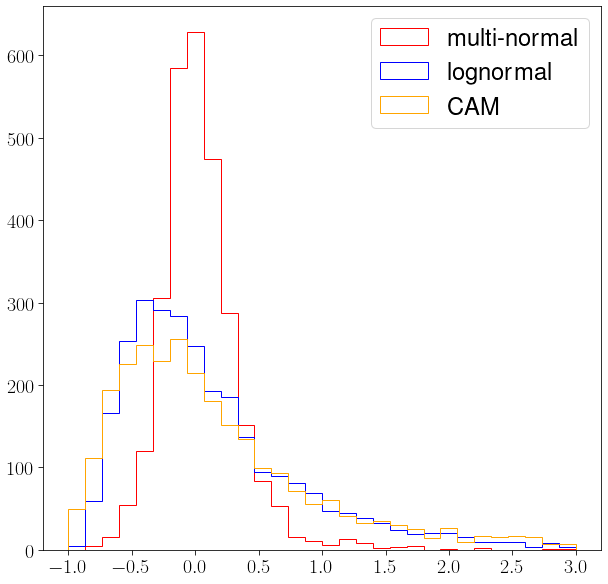

In [24]:
labels = ['multi-normal', 'lognormal', 'CAM']
colors = ['r', 'b', 'orange']
combined_histogram(lam_test, cvir_test, gauss, lognormal, cam, labels=labels, colors=colors)